In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from tools import *

In [2]:
PATH_TO_POSTERIORS = '/Users/ulyana/Documents/GSSI/PhD Projects/GWTC_results/results/posterior_samples/'
PATH_TO_RESULTS = '/Users/ulyana/Documents/GSSI/PhD Projects/GWTC_results/results/'
PATH_TO_INFO = '/Users/ulyana/Documents/GSSI/PhD Projects/GWTC_results/info/'
PATH_TO_PLOTS = '/Users/ulyana/Documents/GSSI/PhD Projects/GWTC_results/plots/'

In [3]:
waveform = 'IMRPhenomXPHM'
estimator = 'median'

In [4]:
events = np.loadtxt(PATH_TO_INFO + 'events_wf_%s_priors_%s.txt' %(estimator, waveform), dtype=str)
with open(PATH_TO_INFO + 'detectors_dictionary.pkl', 'rb') as f:
    detectors = pickle.load(f)

In [5]:
params = ['chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 
            'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']

Calculate the 90% confidence level from all 3 posterior samples

In [6]:
confidence_level = 90 # number between 0 and 100

In [7]:
# lvk, fisher, fisher+priors
cl90_lvk = {}
cl90_fisher = {}
cl90_fisher_plus_priors = {}

for event in events:

    samples_lvk = pd.read_hdf(PATH_TO_POSTERIORS + 'lvk_samples/lvk_samples_%s.hdf5' %(event))
    cl90_lvk[event] = get_confidence_interval(samples_lvk, params, confidence_level)

    samples_fisher = pd.read_hdf(PATH_TO_POSTERIORS + 'fisher_samples/fisher_samples_%s_%s.hdf5' %(estimator, event))
    cl90_fisher[event] = get_confidence_interval(samples_fisher, params, confidence_level)

    samples_fisher_plus_priors = pd.read_hdf(PATH_TO_POSTERIORS + 'fisher_plus_priors_samples/fisher_plus_priors_samples_%s_%s.hdf5' %(estimator, event))
    cl90_fisher_plus_priors[event] = get_confidence_interval(samples_fisher_plus_priors, params, confidence_level)

In [8]:
range_summary = {}
for event in events:
    range_summary[event] = {}
    for param in params:
        range_summary[event][param] = [(cl90_fisher[event][param][1] - cl90_fisher[event][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0]),
                                       (cl90_fisher_plus_priors[event][param][1] - cl90_fisher_plus_priors[event][param][0])/(cl90_lvk[event][param][1] - cl90_lvk[event][param][0])]

In [9]:
fisher_ratio = {key: [] for key in params}
fisher_plus_priors_ratio = {key: [] for key in params}
for param in params:
    for event in events:
        fisher_ratio[param].append(range_summary[event][param][0])
        fisher_plus_priors_ratio[param].append(range_summary[event][param][1])

In [10]:
num_detectors = {}
for event in events:
    num_detectors[event] = len(detectors[event])

In [11]:
lbs_errs = ['snr', 'chirp_mass', 'mass_ratio', 'luminosity_distance', 'dec', 'ra', 'theta_jn',
        'psi', 'phase', 'geocent_time', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl',
        'err_chirp_mass', 'err_mass_ratio', 'err_luminosity_distance', 'err_dec', 'err_ra',
        'err_theta_jn', 'err_psi', 'err_phase', 'err_geocent_time', 'err_a_1', 'err_a_2', 'err_tilt_1',
        'err_tilt_2', 'err_phi_12', 'err_phi_jl', 'err_sky_location']

In [12]:
total_mass_median = []
snr_medians = []
active_detectors = []

for event in events:
    active_detectors.append(num_detectors[event])
    label_err = get_label(detectors, event, estimator, 0, 'errors')
    data = pd.read_csv(PATH_TO_RESULTS + 'gwfish_medians/' + event + '/' + label_err, names = lbs_errs,
                       delimiter = ' ', skiprows = 1)
    m1, m2 = from_mChirp_q_to_m1_m2(data['chirp_mass'].iloc[0], data['mass_ratio'].iloc[0])
    total_mass_median.append(m1 + m2)
    snr_medians.append(data['snr'].iloc[0])

In [13]:
my_palette1 = [(0.6509803921568628, 0.807843137254902, 0.8901960784313725), (0.12156862745098039, 0.47058823529411764, 0.7058823529411765)]
my_palette2 = [(0.9921568627450981, 0.7490196078431373, 0.43529411764705883), (1.0, 0.4980392156862745, 0.0)]

In [14]:
import matplotlib
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12)

In [15]:
plt.rcParams['text.usetex'] = True

In [16]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

In [17]:
param_label = {'chirp_mass': r'$\mathcal{M}_c$', 'mass_ratio': r'$q$', 'luminosity_distance': r'$d_L$',
                'dec': r'$\texttt{DEC}$', 'ra': r'$\texttt{RA}$', 'theta_jn': r'$\theta_{JN}$', 'psi': r'$\Psi$',
                'phase': r'$\phi$', 'geocent_time': r'$t_c$', 'a_1': r'$a_1$', 'a_2': r'$a_2$',
                'tilt_1': r'$\texttt{tilt}_1$', 'tilt_2': r'$\texttt{tilt}_2$', 'phi_12': r'$\texttt{phi}_{12}$',
                'phi_jl': r'$\texttt{phi}_{JL}$'}

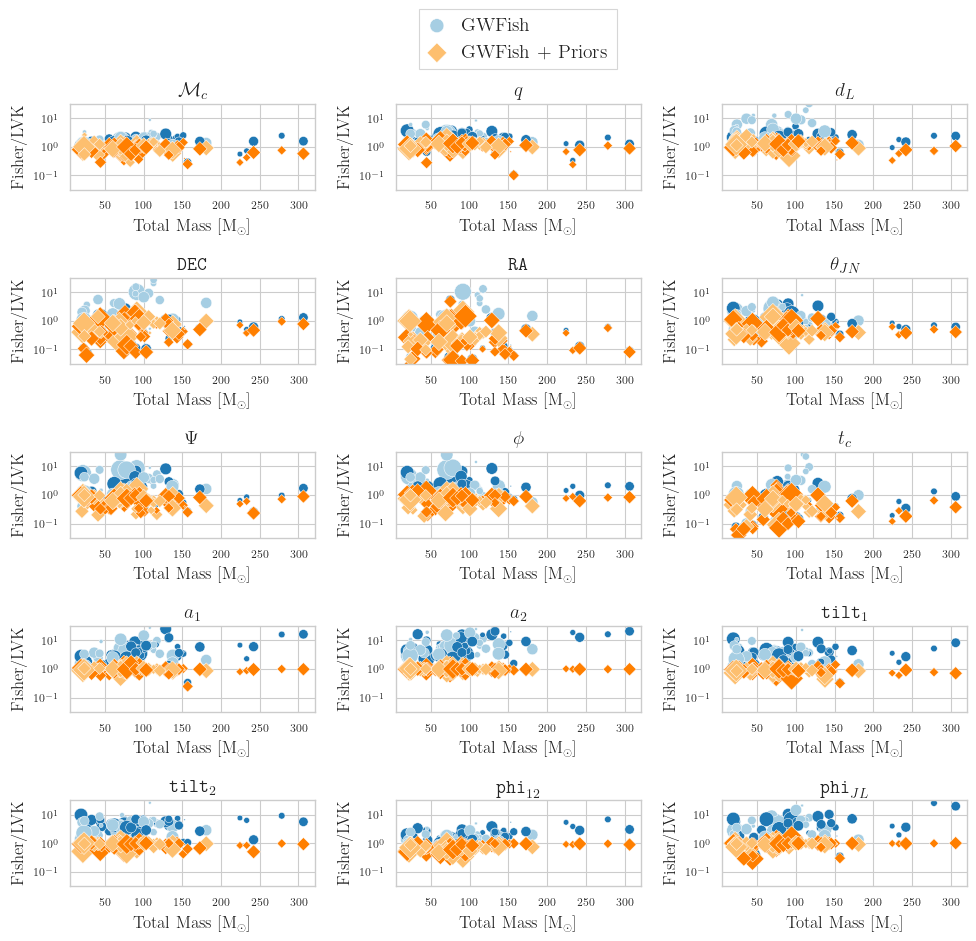

In [18]:
fig, axs = plt.subplots(5, 3, figsize=(10, 10))

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.scatterplot(x = total_mass_median, y = fisher_ratio[param], hue = active_detectors, 
                    sizes=(1, 200), palette=sns.color_palette(my_palette1), size=snr_medians,
                    label = 'GWFish', legend = False, ax = ax)
    ax = sns.scatterplot(x = total_mass_median, y = fisher_plus_priors_ratio[param], 
                         hue = active_detectors, sizes=(1, 200), palette=sns.color_palette(my_palette2),
                         size=snr_medians, marker='D', label = 'GWFish + Priors', legend = False, ax = ax)
    ax.set_xlabel('Total Mass [M$_{\odot}$]', fontsize=12)
    ax.set_ylabel('Fisher/LVK', fontsize=12)
    ax.set_ylim(10**(-1.5), 10**(1.5))
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.set_title('%s' %param_label[param], fontsize=14, weight='bold')
axs[0, 1].legend(fontsize=14, bbox_to_anchor=(0.5, 1.75), loc='center', ncol = 1)


plt.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'summary_plot_%s.png' %estimator, dpi=300)

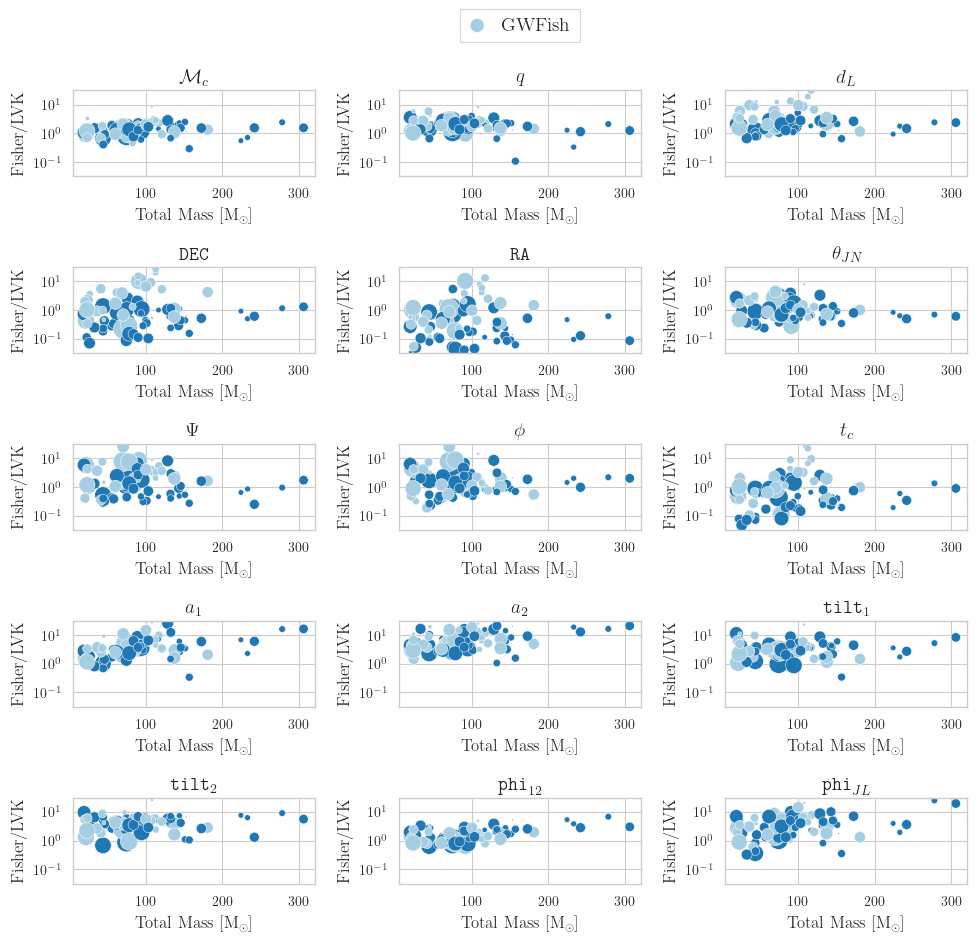

In [19]:
fig, axs = plt.subplots(5, 3, figsize=(10, 10))

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.scatterplot(x = total_mass_median, y = fisher_ratio[param], hue = active_detectors, 
                    sizes=(1, 200), palette=sns.color_palette(my_palette1), size=snr_medians,
                    label = 'GWFish', legend = False, ax = ax)
    ax.set_xlabel('Total Mass [M$_{\odot}$]', fontsize=12)
    ax.set_ylabel('Fisher/LVK', fontsize=12)
    ax.set_ylim(10**(-1.5), 10**(1.5))
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_title('%s' %param_label[param], fontsize=14, weight='bold')
axs[0, 1].legend(fontsize=14, bbox_to_anchor=(0.5, 1.75), loc='center', ncol = 1)


plt.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'gwfish_summary_plot_%s.png' %estimator, dpi=300)

Select those events that have a high SNR in Virgo

In [20]:
virgo_events_list = ['IGWN-GWTC2p1-v2-GW170814_103043_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC2p1-v2-GW170818_022509_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC2p1-v2-GW190701_203306_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC3p0-v2-GW200202_154313_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC3p0-v2-GW200208_222617_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC3p0-v2-GW200224_222234_PEDataRelease_mixed_cosmo',
                     'IGWN-GWTC3p0-v2-GW200311_115853_PEDataRelease_mixed_cosmo']

In [21]:
virgo_total_mass_median = []
virgo_snr_medians = []
virgo_active_detectors = []

for event in virgo_events_list:
    virgo_active_detectors.append(num_detectors[event])
    label_err = get_label(detectors, event, estimator, 0, 'errors')
    data = pd.read_csv(PATH_TO_RESULTS + 'gwfish_medians/' + event + '/' + label_err, names = lbs_errs,
                       delimiter = ' ', skiprows = 1)
    m1, m2 = from_mChirp_q_to_m1_m2(data['chirp_mass'].iloc[0], data['mass_ratio'].iloc[0])
    virgo_total_mass_median.append(m1 + m2)
    virgo_snr_medians.append(data['snr'].iloc[0])

In [22]:
virgo_fisher_ratio = {key: [] for key in params}
virgo_fisher_plus_priors_ratio = {key: [] for key in params}
for param in params:
    for event in virgo_events_list:
        virgo_fisher_ratio[param].append(range_summary[event][param][0])
        virgo_fisher_plus_priors_ratio[param].append(range_summary[event][param][1])

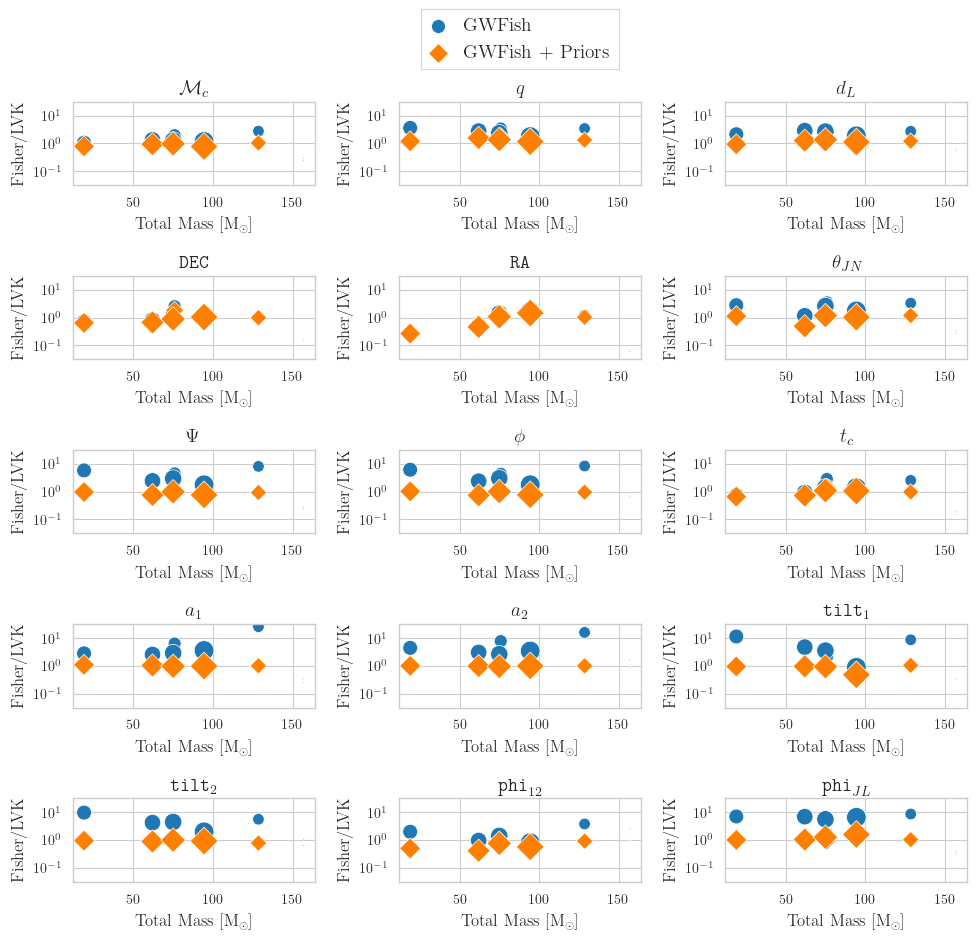

In [23]:
fig, axs = plt.subplots(5, 3, figsize=(10, 10))

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.scatterplot(x = virgo_total_mass_median, y = virgo_fisher_ratio[param],
                    sizes=(1, 200), color = my_palette1[1], size=virgo_snr_medians,
                    label = 'GWFish', legend = False, ax = ax)
    ax = sns.scatterplot(x = virgo_total_mass_median, y = virgo_fisher_plus_priors_ratio[param], 
                         sizes=(1, 200), color = my_palette2[1],
                         size=virgo_snr_medians, marker='D', label = 'GWFish + Priors', legend = False, ax = ax)
    ax.set_xlabel('Total Mass [M$_{\odot}$]', fontsize=12)
    ax.set_ylabel('Fisher/LVK', fontsize=12)
    ax.set_ylim(10**(-1.5), 10**(1.5))
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_title('%s' %param_label[param], fontsize=14, weight='bold')
axs[0, 1].legend(fontsize=14, bbox_to_anchor=(0.5, 1.75), loc='center', ncol = 1)


plt.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'virgo_subsummary_plot_%s.png' %estimator, dpi=300)

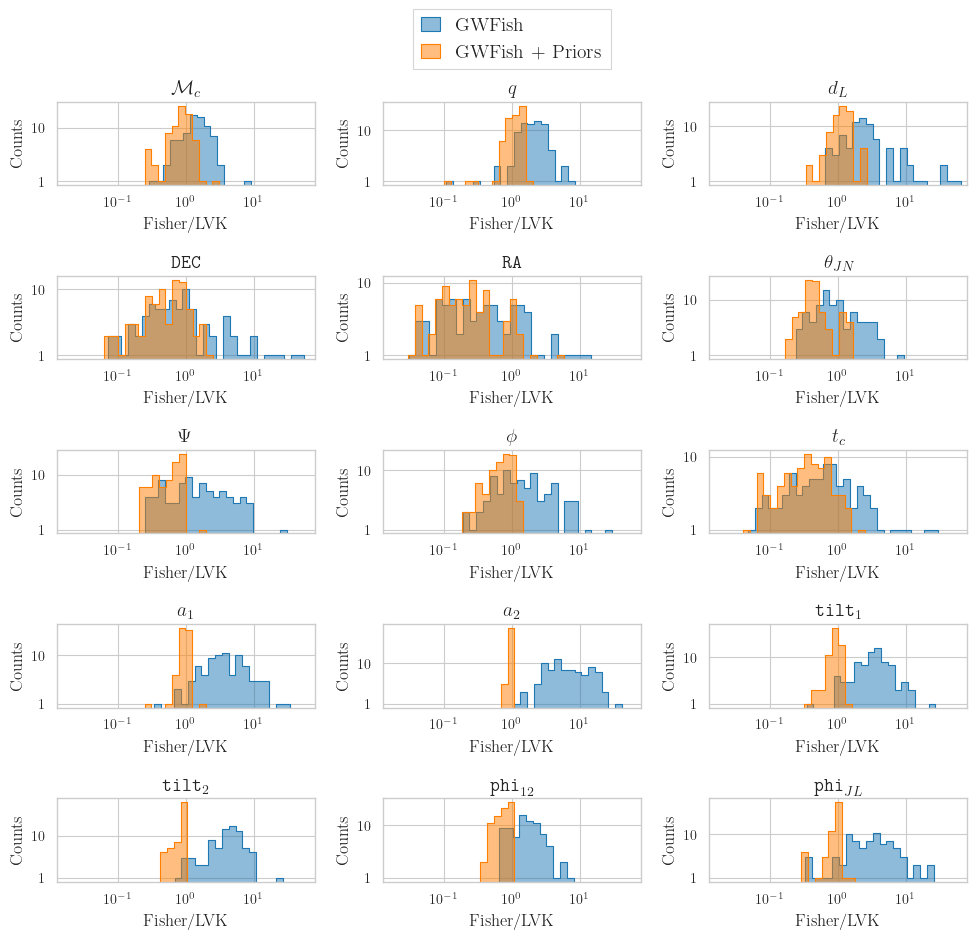

In [24]:
# Plot histograms of ratios
fig, axs = plt.subplots(5, 3, figsize=(10, 10))

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.histplot(fisher_ratio[param], log_scale=True, binwidth=0.1, element='step', ax=ax, label='GWFish', alpha = 0.5, color = my_palette1[1])
    ax = sns.histplot(fisher_plus_priors_ratio[param], log_scale=True, binwidth=0.1, element='step', ax=ax, label='GWFish + Priors', alpha=0.5, color = my_palette2[1])
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_xlabel('Fisher/LVK', fontsize=12)
    ax.set_ylabel('Counts', fontsize=12)
    ax.set_xlim(10**(-1.9), 10**(1.9))
    ax.set_title('%s' %param_label[param], fontsize=14, weight='bold')

axs[0, 1].legend(fontsize=14, bbox_to_anchor=(0.5, 1.75), loc='center', ncol = 1)
plt.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'histograms_%s.png' %estimator, dpi=300)
plt.show()

In [25]:
PATH_TO_INJECTIONS = '/Users/ulyana/Documents/GSSI/PhD Projects/GWTC_results/injections/'

In [26]:
event = 'IGWN-GWTC2p1-v2-GW150914_095045_PEDataRelease_mixed_cosmo'

In [29]:
param_unit = {'chirp_mass': r'[$M_{\odot}$]', 'mass_ratio': r'', 'luminosity_distance': r'[Mpc]',
                'dec': r'[rad]', 'ra': r'[rad]', 'theta_jn': r'[rad]', 'psi': r'[rad]',
                'phase': r'[rad]', 'geocent_time': r'[s]', 'a_1': r'', 'a_2': r'',
                'tilt_1': r'[rad]', 'tilt_2': r'[rad]', 'phi_12': r'[rad]',
                'phi_jl': r'[rad]'}

In [27]:
my_colors = [(1.0, 0.4980392156862745, 0.054901960784313725), #orange
            (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)] #blue

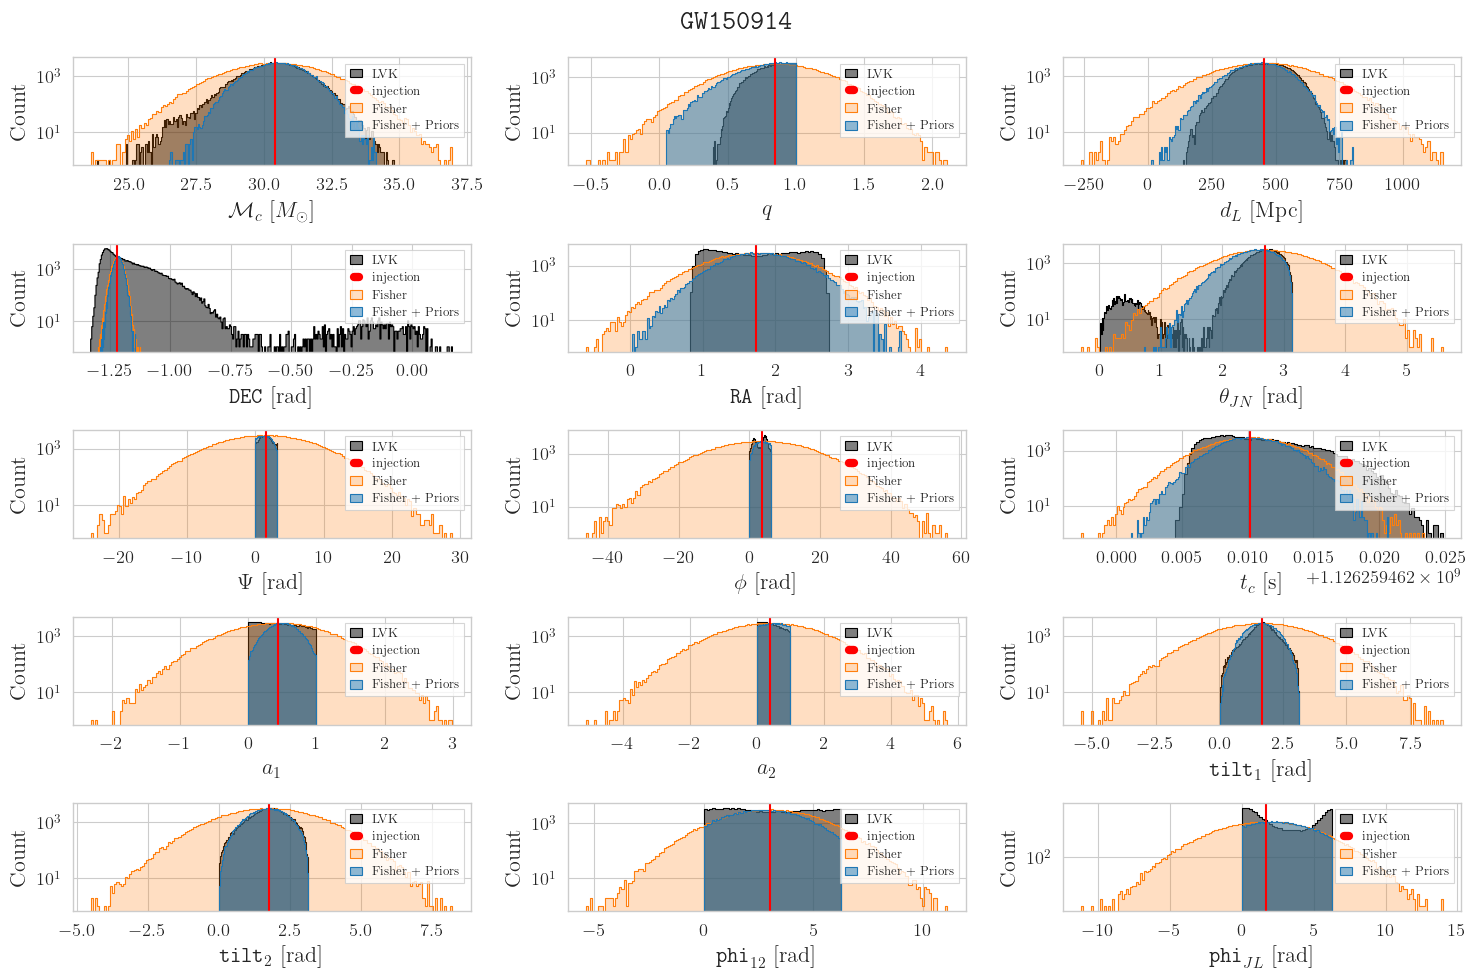

In [31]:
injections = pd.read_hdf(PATH_TO_INJECTIONS + event + '/%s_%s_%s.hdf5' %(event, waveform, estimator))
lvk_samples = pd.read_hdf(PATH_TO_POSTERIORS + 'lvk_samples/lvk_samples_%s.hdf5' %event)
fisher_samples = pd.read_hdf(PATH_TO_POSTERIORS + 'fisher_samples/fisher_samples_%s_%s.hdf5' %(estimator, event))
fisher_plus_priors_samples = pd.read_hdf(PATH_TO_POSTERIORS + 'fisher_plus_priors_samples/fisher_plus_priors_samples_%s_%s.hdf5' %(estimator, event))

fig, axs = plt.subplots(5, 3, figsize=(15, 10))

for i, param in enumerate(params):
    ax = axs[i//3, i%3]
    ax = sns.histplot(lvk_samples[param], element='step', ax=ax, label='LVK', alpha = 0.5, color = 'black')
    ax.axvline(injections[param].values[0], color='red', label = 'injection', linewidth=1.5)
    ax = sns.histplot(fisher_samples[param], element='step', ax=ax, label='Fisher', alpha = 0.25, color = my_colors[0])
    ax = sns.histplot(fisher_plus_priors_samples[param], element='step', ax=ax, label='Fisher + Priors', alpha=0.5, color = my_colors[1])
    
    ax.set_ylabel('Count', fontsize=16)
    ax.set_xlabel('%s %s' %(param_label[param], param_unit[param]), fontsize=16)
    ax.set_yscale('log')
    #ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=12)
    ax.legend(fontsize=9)
#plt.legend(['LVK', 'injection', 'Fisher', 'Fisher + Priors'], fontsize=14, loc='center', ncol = 4)
plt.suptitle(r'$\texttt{GW150914}$', fontsize=20)
plt.tight_layout()
plt.savefig(PATH_TO_PLOTS + 'samples_comparison_%s_%s.png' %(estimator, event), dpi=300)
plt.show()